In [1]:
# Initialization cell
try:  # for CS1302 JupyterLite pyodide kernel
    import piplite

    with open("requirements.txt") as f:
        for package in f:
            package = package.strip()
            print("Installing", package)
            await piplite.install(package)
except ModuleNotFoundError:
    pass

import random
import jupytext
import otter
from ipywidgets import interact

grader = otter.Notebook("main.ipynb")
%reload_ext divewidgets

# Monte Carlo and Root Finding

**CS1302 Introduction to Computer Programming**
___

## The Monty-Hall Game

In [2]:
%%html
<iframe width="800" height="450" src="https://www.youtube.com/embed/rn1y-HrmA5c?end=23" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

**Is it better to change the initial pick? What is the chance of winning if we change?**

```{hint} 
There are two doors to choose from, and only one of the doors has treasure behind it.
```

Let's use the following program to play the game a couple of times.

In [3]:
import random


def play_monty_hall(num_of_doors=3):
    """Main function to run the Monty Hall game."""
    doors = {str(i) for i in range(num_of_doors)}
    door_with_treasure = random.sample(doors, 1)[0]

    # Input the initial pick of the door.
    while True:
        initial_pick = input(f'Pick a door from {", ".join(sorted(doors))}: ')
        if initial_pick in doors:
            break

    # Open all but one other door. The opened door must have nothing.
    doors_to_open = doors - {initial_pick, door_with_treasure}
    other_door = (
        door_with_treasure
        if initial_pick != door_with_treasure
        else doors_to_open.pop()
    )
    print("Door(s) with nothing behind:", *doors_to_open)

    # Allow the player to change the initial pick to the other (unopened) door.
    change_pick = (
        input(f"Would you like to change your choice to {other_door}? [y/N] ").lower()
        == "y"
    )

    # Check and record winning.
    if not change_pick:
        mh_stats["# no change"] += 1
        if door_with_treasure == initial_pick:
            mh_stats["# win without changing"] += 1
            return print("You won!")
    else:
        mh_stats["# change"] += 1
        if door_with_treasure == other_door:
            mh_stats["# win by changing"] += 1
            return print("You won!")
    print(f"You lost. The door with treasure is {door_with_treasure}.")


mh_stats = dict.fromkeys(
    ("# win by changing", "# win without changing", "# change", "# no change"), 0
)


def monty_hall_statistics():
    """Print the statistics of the Monty Hall games."""
    print("-" * 30, "Statistics", "-" * 30)
    if mh_stats["# change"]:
        print(
            f"% win by changing: \
        {mh_stats['# win by changing'] / mh_stats['# change']:.0%}"
        )
    if mh_stats["# no change"]:
        print(
            f"% win without changing: \
        {mh_stats['# win without changing']/mh_stats['# no change']:.0%}"
        )

In [4]:
play_monty_hall()
monty_hall_statistics()

/tmp/ipykernel_4698/3656150097.py:7: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  door_with_treasure = random.sample(doors, 1)[0]


Pick a door from 0, 1, 2:  2


Door(s) with nothing behind: 0


Would you like to change your choice to 1? [y/N]  y


You won!
------------------------------ Statistics ------------------------------
% win by changing:         100%


You may also [play the game online](https://math.ucsd.edu/~crypto/Monty/monty.html).

To get a good estimate of the chance of winning, we need to play the game many times.  
We can write a Monty-Carlo simulation instead.

In [5]:
# Do not change any variables defined here, or some tests may fail.
import numpy as np

np.random.seed(0)  # for reproducible result
num_of_games = int(10e7)
door_with_treasure = np.random.randint(1, 4, num_of_games, dtype=np.uint8)
initial_pick = np.random.randint(1, 4, num_of_games, dtype=np.uint8)

print(f"{'Door with treasure:':>19}", *door_with_treasure[:10], "...")
print(f"{'Initial pick:':>19}", *initial_pick[:10], "...")

Door with treasure: 1 3 1 3 1 2 3 3 1 1 ...
      Initial pick: 1 2 1 2 1 1 1 1 2 2 ...


- `door_with_treasure` stores as 8-bit unsigned integers `uint8` the door numbers randomly chosen from $\{1, 2, 3\}$ as the doors with treasure behind for a number `num_of_games` of Monty-Hall games.
- `initial_pick` stores the initial choices for the different games.

If players do not change their initial pick, the chance of winning can be estimated as follows:

In [6]:
def estimate_chance_of_winning_without_change(door_with_treasure, initial_pick):
    """Estimate the chance of winning the Monty Hall game without changing
    the initial pick using the Monte Carlo simulation of door_with_treasure
    and initial_pick."""
    count_of_win = 0
    for x, y in zip(door_with_treasure, initial_pick):
        if x == y:
            count_of_win += 1
    return count_of_win / n


n = num_of_games // 100
estimate_chance_of_winning_without_change(door_with_treasure[:n], initial_pick[:n])

0.333291

However, the above code is inefficient and takes a long time to run. You may try running it on the entire sequences of `door_with_treasure` and `initial_pick` but **DO NOT** put the code in your notebook, as the server refuses to auto-grade notebooks that take too much time or memory to run.

A simpler and also more efficient solution with well over 100 times speed up is as follows:

In [7]:
def estimate_chance_of_winning_without_change(door_with_treasure, initial_pick):
    """Estimate the chance of winning the Monty Hall game without changing
    the initial pick using the Monte Carlo simulation of door_with_treasure
    and initial_pick."""
    return (door_with_treasure == initial_pick).mean()


estimate_chance_of_winning_without_change(door_with_treasure, initial_pick)

0.33332177

The code uses the method `mean` of `ndarray` that computes the mean of the `numpy` array.  
In computing the mean, `True` and `False` are regarded as `1` and `0`, respectively, as illustrated below.

In [8]:
for i in True, False:
    for j in True, False:
        print(f"{i} + {j} == {i + j}")

True + True == 2
True + False == 1
False + True == 1
False + False == 0


**Exercise** (winning-by-change)

Define the function `estimate_chance_of_winning_by_change` same as `estimate_chance_of_winning_without_change` above but returns the estimate of the chance of winning by changing the initial choice instead. Again, *implement efficiently, or jupyterhub may refuse to auto-grade your entire notebook*.

```{hint}
Since there are only two unopened doors at the end of each game, a player will win by changing the initial pick if the initially picked door is not the door with treasure behind.
```

In [9]:
def estimate_chance_of_winning_by_change(door_with_treasure, initial_pick):
    """Estimate the chance of winning the Monty Hall game by changing
    the initial pick using the Monte Carlo simulation of door_with_treasure
    and initial_pick."""
    return (door_with_treasure !=  initial_pick).mean()

In [10]:
grader.check("winning-by-change")

winning-by-change results: All test cases passed!

## Solving non-linear equations

Suppose we want to solve:

$$
f(x) = 0
$$
for some possibly non-linear real-valued function $f(x)$ in one real-valued variable $x$. A quadratic equation with an $x^2$ term is an example. The following is another example.

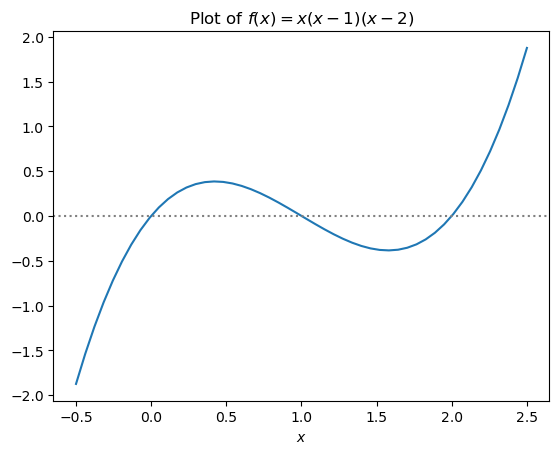

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

f = lambda x: x * (x - 1) * (x - 2)
x = np.linspace(-0.5, 2.5)
plt.plot(x, f(x))
plt.axhline(color="gray", linestyle=":")
plt.xlabel(r"$x$")
plt.title(r"Plot of $f(x)=x(x-1)(x-2)$")
plt.show()

While it is clear that the above function has three roots, namely, $x=0, 1, 2$, can we write a program to compute a root of any given continuous function $f$?

In [12]:
%%html
<iframe width="800" height="450" src="https://www.youtube.com/embed/PXSLcEGkXkU" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

The following function `bisection` 
- takes as arguments 
  - a continuous function `f`,
  - two real values `a` and `b`, 
  - a positive integer `n` indicating the maximum depth of the recursion, and
- returns a list `[xstart, xstop]` if the bisection succeeds in capturing a root in the interval `[xstart, xstop]` bounded by `a` and `b`, or else, returns an empty list `[]`.

In [13]:
def bisection(f, a, b, n=10):
    if f(a) * f(b) > 0:
        return []  # because f(x) may not have a root between x=a and x=b
    elif n <= 0:  # base case when recursion cannot go any deeper
        return [a, b] if a <= b else [b, a]
    else:
        c = (a + b) / 2  # bisect the interval between a and b
        return bisection(f, a, c, n - 1) or bisection(f, c, b, n - 1)  # recursion


# bisection solver
import ipywidgets as widgets


@widgets.interact(a=(-0.5, 2.5, 0.5), b=(-0.5, 2.5, 0.5), n=(0, 10, 1))
def bisection_solver(a=-0.5, b=0.5, n=0):
    x = np.linspace(-0.5, 2.5)
    plt.plot(x, f(x))
    plt.axhline(color="gray", linestyle=":")
    plt.xlabel(r"$x$")
    plt.title(r"Bisection on $f(x)$")
    [xstart, xstop] = bisection(f, a, b, n)
    plt.plot([xstart, xstop], [0, 0], "r|-")
    print("Interval: ", [xstart, xstop])

interactive(children=(FloatSlider(value=-0.5, description='a', max=2.5, min=-0.5, step=0.5), FloatSlider(value…

Try setting the values of $a$ and $b$ as follows and change $n$ to see the change of the interval step-by-step.

In [14]:
bisection(f, -0.5, 0.5), bisection(f, 1.5, 0.5), bisection(f, -0.1, 2.5)

([-0.0009765625, 0.0], [1.0, 1.0009765625], [1.9998046875000002, 2.00234375])

**Exercise** (bisection)

Modify the function `bisection` to 
- take the floating point parameter `tol` instead of `n`, and
- return the interval from the bisection method represented by a list `[xstart,xstop]`, but as soon as the gap `xstop - xstart` is $\leq$ `tol`.

In [15]:
def bisection(f, a, b, tol=1e-9):
    if f(a) * f(b) > 0:
        return []
    elif abs(a - b) <= tol:
        return [a, b] if a <= b else [b, a]
    c = (a + b) / 2
    return bisection(f, a, c, tol) or bisection(f, c, b, tol)

In [16]:
grader.check("bisection")

bisection results: All test cases passed!

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [17]:
# extra files to submit
extra_files = []

In [18]:
# Generate the source main.py necessary for grading and similarity check.
jupytext.write(jupytext.read("main.ipynb"), "main.py", fmt="py:percent")

In [19]:
# Generate the zip file to submit.
grader.export(pdf=False, run_tests=False, files=["main.py", *extra_files])